## download data

In [1]:
### linux
#!apt-get install wget
### mac
#!brew install wget
 
### create a data directory
#!mkdir data_dir
 
### download images and annotations to the data directory
#!wget http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip -P ./data_dir/
#!wget http://images.cocodataset.org/zips/train2014.zip -P ./data_dir/
#!wget http://images.cocodataset.org/zips/val2014.zip -P ./data_dir/
    
### extract zipped images and annotations and remove the zip files
#!unzip ./data_dir/captions_train-val2014.zip -d ./data_dir/
#!rm ./data_dir/captions_train-val2014.zip
#!unzip ./data_dir/train2014.zip -d ./data_dir/
#!rm ./data_dir/train2014.zip 
#!unzip ./data_dir/val2014.zip -d ./data_dir/ 
#!rm ./data_dir/val2014.zip

In [2]:
# Windows를 포함한 모든 환경에서 실습할 수 있게 파이썬 코드를 작성했습니다. - 위키북스

import urllib
import zipfile
from tqdm import tqdm

#https://stackoverflow.com/a/53877507/1558946
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_data(url):
    print(f"{url} 다운로드 중 ...")
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        zip_path, _ = urllib.request.urlretrieve(url, reporthook=t.update_to)

    print("압축을 푸는 중 ...")
    with zipfile.ZipFile(zip_path, "r") as f:
        for name in tqdm(iterable=f.namelist(), total=len(f.namelist())):
            f.extract(member=name, path="data_dir")


download_data("http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip")
download_data("http://images.cocodataset.org/zips/train2014.zip")
download_data("http://images.cocodataset.org/zips/val2014.zip")

http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip 다운로드 중 ...


captions_train-val2014.zip: 19.7MB [00:09, 2.15MB/s]                                                                                                                                                                                                                        


압축을 푸는 중 ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.25it/s]


http://images.cocodataset.org/zips/train2014.zip 다운로드 중 ...


train2014.zip: 13.5GB [22:54, 9.83MB/s]                                                                                                                                                                                                                                     


압축을 푸는 중 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82784/82784 [09:04<00:00, 151.94it/s]


http://images.cocodataset.org/zips/val2014.zip 다운로드 중 ...


val2014.zip: 6.65GB [08:25, 13.1MB/s]                                                                                                                                                                                                                                       


압축을 푸는 중 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40505/40505 [03:52<00:00, 174.47it/s]


## import dependencies

In [3]:
import os
import nltk
import pickle
import numpy as np
from PIL import Image
from collections import Counter
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
 
import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision import transforms
import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pack_padded_sequence

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sk8er\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## build vocab

In [5]:
class Vocab(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.w2i = {}
        self.i2w = {}
        self.index = 0
 
    def __call__(self, token):
        if not token in self.w2i:
            return self.w2i['<unk>']
        return self.w2i[token]
 
    def __len__(self):
        return len(self.w2i)
    def add_token(self, token):
        if not token in self.w2i:
            self.w2i[token] = self.index
            self.i2w[self.index] = token
            self.index += 1

def build_vocabulary(json, threshold):
    """Build a simple vocabulary wrapper."""
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)
 
        if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))
 
    # If the word frequency is less than 'threshold', then the word is discarded.
    tokens = [token for token, cnt in counter.items() if cnt >= threshold]
 
    # Create a vocab wrapper and add some special tokens.
    vocab = Vocab()
    vocab.add_token('<pad>')
    vocab.add_token('<start>')
    vocab.add_token('<end>')
    vocab.add_token('<unk>')
 
    # Add the words to the vocabulary.
    for i, token in enumerate(tokens):
        vocab.add_token(token)
    return vocab
 
vocab = build_vocabulary(json='data_dir/annotations/captions_train2014.json', threshold=4)
vocab_path = './data_dir/vocabulary.pkl'
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)
print("Total vocabulary size: {}".format(len(vocab)))
print("Saved the vocabulary wrapper to '{}'".format(vocab_path))

loading annotations into memory...
Done (t=1.43s)
creating index...
index created!
[1000/414113] Tokenized the captions.
[2000/414113] Tokenized the captions.
[3000/414113] Tokenized the captions.
[4000/414113] Tokenized the captions.
[5000/414113] Tokenized the captions.
[6000/414113] Tokenized the captions.
[7000/414113] Tokenized the captions.
[8000/414113] Tokenized the captions.
[9000/414113] Tokenized the captions.
[10000/414113] Tokenized the captions.
[11000/414113] Tokenized the captions.
[12000/414113] Tokenized the captions.
[13000/414113] Tokenized the captions.
[14000/414113] Tokenized the captions.
[15000/414113] Tokenized the captions.
[16000/414113] Tokenized the captions.
[17000/414113] Tokenized the captions.
[18000/414113] Tokenized the captions.
[19000/414113] Tokenized the captions.
[20000/414113] Tokenized the captions.
[21000/414113] Tokenized the captions.
[22000/414113] Tokenized the captions.
[23000/414113] Tokenized the captions.
[24000/414113] Tokenized the 

[208000/414113] Tokenized the captions.
[209000/414113] Tokenized the captions.
[210000/414113] Tokenized the captions.
[211000/414113] Tokenized the captions.
[212000/414113] Tokenized the captions.
[213000/414113] Tokenized the captions.
[214000/414113] Tokenized the captions.
[215000/414113] Tokenized the captions.
[216000/414113] Tokenized the captions.
[217000/414113] Tokenized the captions.
[218000/414113] Tokenized the captions.
[219000/414113] Tokenized the captions.
[220000/414113] Tokenized the captions.
[221000/414113] Tokenized the captions.
[222000/414113] Tokenized the captions.
[223000/414113] Tokenized the captions.
[224000/414113] Tokenized the captions.
[225000/414113] Tokenized the captions.
[226000/414113] Tokenized the captions.
[227000/414113] Tokenized the captions.
[228000/414113] Tokenized the captions.
[229000/414113] Tokenized the captions.
[230000/414113] Tokenized the captions.
[231000/414113] Tokenized the captions.
[232000/414113] Tokenized the captions.


Total vocabulary size: 9948
Saved the vocabulary wrapper to './data_dir/vocabulary.pkl'


## resize images

In [6]:
def reshape_image(image, shape):
    """Resize an image to the given shape."""
    return image.resize(shape, Image.ANTIALIAS)
 
def reshape_images(image_path, output_path, shape):
    """Reshape the images in 'image_path' and save into 'output_path'."""
    if not os.path.exists(output_path):
        os.makedirs(output_path)
 
    images = os.listdir(image_path)
    num_im = len(images)
    for i, im in enumerate(images):
        with open(os.path.join(image_path, im), 'r+b') as f:
            with Image.open(f) as image:
                image = reshape_image(image, shape)
                image.save(os.path.join(output_path, im), image.format)
        if (i+1) % 100 == 0:
            print ("[{}/{}] Resized the images and saved into '{}'."
                   .format(i+1, num_im, output_path))

image_path = './data_dir/train2014/'
output_path = './data_dir/resized_images/'
image_shape = [256, 256]
reshape_images(image_path, output_path, image_shape)

[100/82783] Resized the images and saved into './data_dir/resized_images/'.
[200/82783] Resized the images and saved into './data_dir/resized_images/'.
[300/82783] Resized the images and saved into './data_dir/resized_images/'.
[400/82783] Resized the images and saved into './data_dir/resized_images/'.
[500/82783] Resized the images and saved into './data_dir/resized_images/'.
[600/82783] Resized the images and saved into './data_dir/resized_images/'.
[700/82783] Resized the images and saved into './data_dir/resized_images/'.
[800/82783] Resized the images and saved into './data_dir/resized_images/'.
[900/82783] Resized the images and saved into './data_dir/resized_images/'.
[1000/82783] Resized the images and saved into './data_dir/resized_images/'.
[1100/82783] Resized the images and saved into './data_dir/resized_images/'.
[1200/82783] Resized the images and saved into './data_dir/resized_images/'.
[1300/82783] Resized the images and saved into './data_dir/resized_images/'.
[1400/82

[10800/82783] Resized the images and saved into './data_dir/resized_images/'.
[10900/82783] Resized the images and saved into './data_dir/resized_images/'.
[11000/82783] Resized the images and saved into './data_dir/resized_images/'.
[11100/82783] Resized the images and saved into './data_dir/resized_images/'.
[11200/82783] Resized the images and saved into './data_dir/resized_images/'.
[11300/82783] Resized the images and saved into './data_dir/resized_images/'.
[11400/82783] Resized the images and saved into './data_dir/resized_images/'.
[11500/82783] Resized the images and saved into './data_dir/resized_images/'.
[11600/82783] Resized the images and saved into './data_dir/resized_images/'.
[11700/82783] Resized the images and saved into './data_dir/resized_images/'.
[11800/82783] Resized the images and saved into './data_dir/resized_images/'.
[11900/82783] Resized the images and saved into './data_dir/resized_images/'.
[12000/82783] Resized the images and saved into './data_dir/resi

[21400/82783] Resized the images and saved into './data_dir/resized_images/'.
[21500/82783] Resized the images and saved into './data_dir/resized_images/'.
[21600/82783] Resized the images and saved into './data_dir/resized_images/'.
[21700/82783] Resized the images and saved into './data_dir/resized_images/'.
[21800/82783] Resized the images and saved into './data_dir/resized_images/'.
[21900/82783] Resized the images and saved into './data_dir/resized_images/'.
[22000/82783] Resized the images and saved into './data_dir/resized_images/'.
[22100/82783] Resized the images and saved into './data_dir/resized_images/'.
[22200/82783] Resized the images and saved into './data_dir/resized_images/'.
[22300/82783] Resized the images and saved into './data_dir/resized_images/'.
[22400/82783] Resized the images and saved into './data_dir/resized_images/'.
[22500/82783] Resized the images and saved into './data_dir/resized_images/'.
[22600/82783] Resized the images and saved into './data_dir/resi

[32000/82783] Resized the images and saved into './data_dir/resized_images/'.
[32100/82783] Resized the images and saved into './data_dir/resized_images/'.
[32200/82783] Resized the images and saved into './data_dir/resized_images/'.
[32300/82783] Resized the images and saved into './data_dir/resized_images/'.
[32400/82783] Resized the images and saved into './data_dir/resized_images/'.
[32500/82783] Resized the images and saved into './data_dir/resized_images/'.
[32600/82783] Resized the images and saved into './data_dir/resized_images/'.
[32700/82783] Resized the images and saved into './data_dir/resized_images/'.
[32800/82783] Resized the images and saved into './data_dir/resized_images/'.
[32900/82783] Resized the images and saved into './data_dir/resized_images/'.
[33000/82783] Resized the images and saved into './data_dir/resized_images/'.
[33100/82783] Resized the images and saved into './data_dir/resized_images/'.
[33200/82783] Resized the images and saved into './data_dir/resi

[42600/82783] Resized the images and saved into './data_dir/resized_images/'.
[42700/82783] Resized the images and saved into './data_dir/resized_images/'.
[42800/82783] Resized the images and saved into './data_dir/resized_images/'.
[42900/82783] Resized the images and saved into './data_dir/resized_images/'.
[43000/82783] Resized the images and saved into './data_dir/resized_images/'.
[43100/82783] Resized the images and saved into './data_dir/resized_images/'.
[43200/82783] Resized the images and saved into './data_dir/resized_images/'.
[43300/82783] Resized the images and saved into './data_dir/resized_images/'.
[43400/82783] Resized the images and saved into './data_dir/resized_images/'.
[43500/82783] Resized the images and saved into './data_dir/resized_images/'.
[43600/82783] Resized the images and saved into './data_dir/resized_images/'.
[43700/82783] Resized the images and saved into './data_dir/resized_images/'.
[43800/82783] Resized the images and saved into './data_dir/resi

[53200/82783] Resized the images and saved into './data_dir/resized_images/'.
[53300/82783] Resized the images and saved into './data_dir/resized_images/'.
[53400/82783] Resized the images and saved into './data_dir/resized_images/'.
[53500/82783] Resized the images and saved into './data_dir/resized_images/'.
[53600/82783] Resized the images and saved into './data_dir/resized_images/'.
[53700/82783] Resized the images and saved into './data_dir/resized_images/'.
[53800/82783] Resized the images and saved into './data_dir/resized_images/'.
[53900/82783] Resized the images and saved into './data_dir/resized_images/'.
[54000/82783] Resized the images and saved into './data_dir/resized_images/'.
[54100/82783] Resized the images and saved into './data_dir/resized_images/'.
[54200/82783] Resized the images and saved into './data_dir/resized_images/'.
[54300/82783] Resized the images and saved into './data_dir/resized_images/'.
[54400/82783] Resized the images and saved into './data_dir/resi

[63800/82783] Resized the images and saved into './data_dir/resized_images/'.
[63900/82783] Resized the images and saved into './data_dir/resized_images/'.
[64000/82783] Resized the images and saved into './data_dir/resized_images/'.
[64100/82783] Resized the images and saved into './data_dir/resized_images/'.
[64200/82783] Resized the images and saved into './data_dir/resized_images/'.
[64300/82783] Resized the images and saved into './data_dir/resized_images/'.
[64400/82783] Resized the images and saved into './data_dir/resized_images/'.
[64500/82783] Resized the images and saved into './data_dir/resized_images/'.
[64600/82783] Resized the images and saved into './data_dir/resized_images/'.
[64700/82783] Resized the images and saved into './data_dir/resized_images/'.
[64800/82783] Resized the images and saved into './data_dir/resized_images/'.
[64900/82783] Resized the images and saved into './data_dir/resized_images/'.
[65000/82783] Resized the images and saved into './data_dir/resi

[74400/82783] Resized the images and saved into './data_dir/resized_images/'.
[74500/82783] Resized the images and saved into './data_dir/resized_images/'.
[74600/82783] Resized the images and saved into './data_dir/resized_images/'.
[74700/82783] Resized the images and saved into './data_dir/resized_images/'.
[74800/82783] Resized the images and saved into './data_dir/resized_images/'.
[74900/82783] Resized the images and saved into './data_dir/resized_images/'.
[75000/82783] Resized the images and saved into './data_dir/resized_images/'.
[75100/82783] Resized the images and saved into './data_dir/resized_images/'.
[75200/82783] Resized the images and saved into './data_dir/resized_images/'.
[75300/82783] Resized the images and saved into './data_dir/resized_images/'.
[75400/82783] Resized the images and saved into './data_dir/resized_images/'.
[75500/82783] Resized the images and saved into './data_dir/resized_images/'.
[75600/82783] Resized the images and saved into './data_dir/resi

## instantiate data loader

In [7]:
class CustomCocoDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, data_path, coco_json_path, vocabulary, transform=None):
        """Set the path for images, captions and vocabulary wrapper.
        
        Args:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.root = data_path
        self.coco_data = COCO(coco_json_path)
        self.indices = list(self.coco_data.anns.keys())
        self.vocabulary = vocabulary
        self.transform = transform
 
    def __getitem__(self, idx):
        """Returns one data pair (image and caption)."""
        coco_data = self.coco_data
        vocabulary = self.vocabulary
        annotation_id = self.indices[idx]
        caption = coco_data.anns[annotation_id]['caption']
        image_id = coco_data.anns[annotation_id]['image_id']
        image_path = coco_data.loadImgs(image_id)[0]['file_name']
 
        image = Image.open(os.path.join(self.root, image_path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
 
        # Convert caption (string) to word ids.
        word_tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocabulary('<start>'))
        caption.extend([vocabulary(token) for token in word_tokens])
        caption.append(vocabulary('<end>'))
        ground_truth = torch.Tensor(caption)
        return image, ground_truth
 
    def __len__(self):
        return len(self.indices)
 
 
def collate_function(data_batch):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    We should build custom collate_fn rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data_batch.sort(key=lambda d: len(d[1]), reverse=True)
    imgs, caps = zip(*data_batch)
 
    # Merge images (from list of 3D tensors to 4D tensor).
    # Originally, imgs is a list of <batch_size> number of RGB images with dimensions (3, 256, 256)
    # This line of code turns it into a single tensor of dimensions (<batch_size>, 3, 256, 256)
    imgs = torch.stack(imgs, 0)
 
    # Merge captions (from list of 1D tensors to 2D tensor), similar to merging of images donw above.
    cap_lens = [len(cap) for cap in caps]
    tgts = torch.zeros(len(caps), max(cap_lens)).long()
    for i, cap in enumerate(caps):
        end = cap_lens[i]
        tgts[i, :end] = cap[:end]        
    return imgs, tgts, cap_lens
 
def get_loader(data_path, coco_json_path, vocabulary, transform, batch_size, shuffle, num_workers):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # COCO caption dataset
    coco_dataser = CustomCocoDataset(data_path=data_path,
                       coco_json_path=coco_json_path,
                       vocabulary=vocabulary,
                       transform=transform)
    
    # Data loader for COCO dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    custom_data_loader = torch.utils.data.DataLoader(dataset=coco_dataser, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_function)
    return custom_data_loader

## model definition

In [8]:
class CNNModel(nn.Module):
    def __init__(self, embedding_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(CNNModel, self).__init__()
        resnet = models.resnet152(pretrained=True)
        module_list = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet_module = nn.Sequential(*module_list)
        self.linear_layer = nn.Linear(resnet.fc.in_features, embedding_size)
        self.batch_norm = nn.BatchNorm1d(embedding_size, momentum=0.01)
        
    def forward(self, input_images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            resnet_features = self.resnet_module(input_images)
        resnet_features = resnet_features.reshape(resnet_features.size(0), -1)
        final_features = self.batch_norm(self.linear_layer(resnet_features))
        return final_features
 
 
class LSTMModel(nn.Module):
    def __init__(self, embedding_size, hidden_layer_size, vocabulary_size, num_layers, max_seq_len=20):
        """Set the hyper-parameters and build the layers."""
        super(LSTMModel, self).__init__()
        self.embedding_layer = nn.Embedding(vocabulary_size, embedding_size)
        self.lstm_layer = nn.LSTM(embedding_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear_layer = nn.Linear(hidden_layer_size, vocabulary_size)
        self.max_seq_len = max_seq_len
        
    def forward(self, input_features, capts, lens):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embedding_layer(caps)
        embeddings = torch.cat((input_features.unsqueeze(1), embeddings), 1)
        lstm_input = pack_padded_sequence(embeddings, lens, batch_first=True) 
        hidden_variables, _ = self.lstm_layer(lstm_input)
        model_outputs = self.linear_layer(hidden_variables[0])
        return model_outputs
    
    def sample(self, input_features, lstm_states=None):
        """Generate captions for given image features using greedy search."""
        sampled_indices = []
        lstm_inputs = input_features.unsqueeze(1)
        for i in range(self.max_seq_len):
            hidden_variables, lstm_states = self.lstm_layer(lstm_inputs, lstm_states)          # hiddens: (batch_size, 1, hidden_size)
            model_outputs = self.linear_layer(hidden_variables.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted_outputs = model_outputs.max(1)                        # predicted: (batch_size)
            sampled_indices.append(predicted_outputs)
            lstm_inputs = self.embedding_layer(predicted_outputs)                       # inputs: (batch_size, embed_size)
            lstm_inputs = lstm_inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_indices = torch.stack(sampled_indices, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_indices

## training loop

In [9]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Create model directory
if not os.path.exists('models_dir/'):
    os.makedirs('models_dir/')

    
# Image preprocessing, normalization for the pretrained resnet
transform = transforms.Compose([ 
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])


# Load vocabulary wrapper
with open('data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)

    
# Build data loader
custom_data_loader = get_loader('data_dir/resized_images', 'data_dir/annotations/captions_train2014.json', vocabulary, 
                         transform, 128,
                         shuffle=True, num_workers=0) 


# Build the models
encoder_model = CNNModel(256).to(device)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1).to(device)
 
    
# Loss and optimizer
loss_criterion = nn.CrossEntropyLoss()
parameters = list(decoder_model.parameters()) + list(encoder_model.linear_layer.parameters()) + list(encoder_model.batch_norm.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.001)


# Train the models
total_num_steps = len(custom_data_loader)
for epoch in range(5):
    for i, (imgs, caps, lens) in enumerate(custom_data_loader):
 
        # Set mini-batch dataset
        imgs = imgs.to(device)
        caps = caps.to(device)
        tgts = pack_padded_sequence(caps, lens, batch_first=True)[0]
 
        # Forward, backward and optimize
        feats = encoder_model(imgs)
        outputs = decoder_model(feats, caps, lens)
        loss = loss_criterion(outputs, tgts)
        decoder_model.zero_grad()
        encoder_model.zero_grad()
        loss.backward()
        optimizer.step()
 
        # Print log info
        if i % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, 5, i, total_num_steps, loss.item(),
                          np.exp(loss.item()))) 
 
        # Save the model checkpoints
        if (i+1) % 1000 == 0:
            torch.save(decoder_model.state_dict(), os.path.join(
                'models_dir/', 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
            torch.save(encoder_model.state_dict(), os.path.join(
                'models_dir/', 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))

loading annotations into memory...
Done (t=1.26s)
creating index...
index created!
Epoch [0/5], Step [0/3236], Loss: 9.2067, Perplexity: 9963.6372
Epoch [0/5], Step [10/3236], Loss: 5.7833, Perplexity: 324.8267
Epoch [0/5], Step [20/3236], Loss: 5.3595, Perplexity: 212.6108
Epoch [0/5], Step [30/3236], Loss: 4.8946, Perplexity: 133.5606
Epoch [0/5], Step [40/3236], Loss: 4.5756, Perplexity: 97.0884
Epoch [0/5], Step [50/3236], Loss: 4.2393, Perplexity: 69.3584
Epoch [0/5], Step [60/3236], Loss: 4.1522, Perplexity: 63.5745
Epoch [0/5], Step [70/3236], Loss: 3.9544, Perplexity: 52.1624
Epoch [0/5], Step [80/3236], Loss: 3.9461, Perplexity: 51.7330
Epoch [0/5], Step [90/3236], Loss: 3.9528, Perplexity: 52.0805
Epoch [0/5], Step [100/3236], Loss: 3.8631, Perplexity: 47.6121
Epoch [0/5], Step [110/3236], Loss: 3.7731, Perplexity: 43.5144
Epoch [0/5], Step [120/3236], Loss: 3.7061, Perplexity: 40.6929
Epoch [0/5], Step [130/3236], Loss: 3.7187, Perplexity: 41.2093
Epoch [0/5], Step [140/3236

Epoch [0/5], Step [1270/3236], Loss: 2.4474, Perplexity: 11.5581
Epoch [0/5], Step [1280/3236], Loss: 2.6049, Perplexity: 13.5305
Epoch [0/5], Step [1290/3236], Loss: 2.5559, Perplexity: 12.8831
Epoch [0/5], Step [1300/3236], Loss: 2.4245, Perplexity: 11.2966
Epoch [0/5], Step [1310/3236], Loss: 2.5827, Perplexity: 13.2325
Epoch [0/5], Step [1320/3236], Loss: 2.3917, Perplexity: 10.9323
Epoch [0/5], Step [1330/3236], Loss: 2.5032, Perplexity: 12.2221
Epoch [0/5], Step [1340/3236], Loss: 2.4949, Perplexity: 12.1201
Epoch [0/5], Step [1350/3236], Loss: 2.5014, Perplexity: 12.1996
Epoch [0/5], Step [1360/3236], Loss: 2.5055, Perplexity: 12.2501
Epoch [0/5], Step [1370/3236], Loss: 2.4499, Perplexity: 11.5873
Epoch [0/5], Step [1380/3236], Loss: 2.5968, Perplexity: 13.4202
Epoch [0/5], Step [1390/3236], Loss: 2.4243, Perplexity: 11.2944
Epoch [0/5], Step [1400/3236], Loss: 2.4228, Perplexity: 11.2776
Epoch [0/5], Step [1410/3236], Loss: 2.5506, Perplexity: 12.8148
Epoch [0/5], Step [1420/3

Epoch [0/5], Step [2540/3236], Loss: 2.2747, Perplexity: 9.7246
Epoch [0/5], Step [2550/3236], Loss: 2.5228, Perplexity: 12.4633
Epoch [0/5], Step [2560/3236], Loss: 2.3483, Perplexity: 10.4680
Epoch [0/5], Step [2570/3236], Loss: 2.2194, Perplexity: 9.2021
Epoch [0/5], Step [2580/3236], Loss: 2.3787, Perplexity: 10.7905
Epoch [0/5], Step [2590/3236], Loss: 2.2430, Perplexity: 9.4214
Epoch [0/5], Step [2600/3236], Loss: 2.3172, Perplexity: 10.1469
Epoch [0/5], Step [2610/3236], Loss: 2.2223, Perplexity: 9.2282
Epoch [0/5], Step [2620/3236], Loss: 2.1757, Perplexity: 8.8087
Epoch [0/5], Step [2630/3236], Loss: 2.3835, Perplexity: 10.8431
Epoch [0/5], Step [2640/3236], Loss: 2.2628, Perplexity: 9.6103
Epoch [0/5], Step [2650/3236], Loss: 2.2792, Perplexity: 9.7691
Epoch [0/5], Step [2660/3236], Loss: 2.2584, Perplexity: 9.5678
Epoch [0/5], Step [2670/3236], Loss: 2.4552, Perplexity: 11.6486
Epoch [0/5], Step [2680/3236], Loss: 2.3108, Perplexity: 10.0821
Epoch [0/5], Step [2690/3236], Lo

Epoch [1/5], Step [590/3236], Loss: 2.1327, Perplexity: 8.4377
Epoch [1/5], Step [600/3236], Loss: 2.1341, Perplexity: 8.4494
Epoch [1/5], Step [610/3236], Loss: 2.1448, Perplexity: 8.5403
Epoch [1/5], Step [620/3236], Loss: 2.1454, Perplexity: 8.5458
Epoch [1/5], Step [630/3236], Loss: 2.2509, Perplexity: 9.4961
Epoch [1/5], Step [640/3236], Loss: 2.0491, Perplexity: 7.7605
Epoch [1/5], Step [650/3236], Loss: 2.2551, Perplexity: 9.5367
Epoch [1/5], Step [660/3236], Loss: 2.0744, Perplexity: 7.9600
Epoch [1/5], Step [670/3236], Loss: 2.1119, Perplexity: 8.2637
Epoch [1/5], Step [680/3236], Loss: 2.2715, Perplexity: 9.6940
Epoch [1/5], Step [690/3236], Loss: 2.0712, Perplexity: 7.9346
Epoch [1/5], Step [700/3236], Loss: 2.1335, Perplexity: 8.4447
Epoch [1/5], Step [710/3236], Loss: 2.2631, Perplexity: 9.6132
Epoch [1/5], Step [720/3236], Loss: 2.0277, Perplexity: 7.5965
Epoch [1/5], Step [730/3236], Loss: 2.2460, Perplexity: 9.4500
Epoch [1/5], Step [740/3236], Loss: 1.9652, Perplexity:

Epoch [1/5], Step [1880/3236], Loss: 2.1441, Perplexity: 8.5343
Epoch [1/5], Step [1890/3236], Loss: 2.1999, Perplexity: 9.0243
Epoch [1/5], Step [1900/3236], Loss: 2.1869, Perplexity: 8.9079
Epoch [1/5], Step [1910/3236], Loss: 2.0463, Perplexity: 7.7388
Epoch [1/5], Step [1920/3236], Loss: 2.0183, Perplexity: 7.5254
Epoch [1/5], Step [1930/3236], Loss: 2.0806, Perplexity: 8.0094
Epoch [1/5], Step [1940/3236], Loss: 2.1572, Perplexity: 8.6466
Epoch [1/5], Step [1950/3236], Loss: 2.0063, Perplexity: 7.4356
Epoch [1/5], Step [1960/3236], Loss: 1.9787, Perplexity: 7.2332
Epoch [1/5], Step [1970/3236], Loss: 2.0899, Perplexity: 8.0840
Epoch [1/5], Step [1980/3236], Loss: 2.0174, Perplexity: 7.5188
Epoch [1/5], Step [1990/3236], Loss: 2.1757, Perplexity: 8.8085
Epoch [1/5], Step [2000/3236], Loss: 2.0291, Perplexity: 7.6071
Epoch [1/5], Step [2010/3236], Loss: 2.1189, Perplexity: 8.3223
Epoch [1/5], Step [2020/3236], Loss: 2.0824, Perplexity: 8.0240
Epoch [1/5], Step [2030/3236], Loss: 2.0

Epoch [1/5], Step [3160/3236], Loss: 1.9624, Perplexity: 7.1160
Epoch [1/5], Step [3170/3236], Loss: 2.0999, Perplexity: 8.1656
Epoch [1/5], Step [3180/3236], Loss: 2.0726, Perplexity: 7.9457
Epoch [1/5], Step [3190/3236], Loss: 2.1618, Perplexity: 8.6872
Epoch [1/5], Step [3200/3236], Loss: 2.0674, Perplexity: 7.9039
Epoch [1/5], Step [3210/3236], Loss: 2.0597, Perplexity: 7.8437
Epoch [1/5], Step [3220/3236], Loss: 2.1411, Perplexity: 8.5091
Epoch [1/5], Step [3230/3236], Loss: 2.0697, Perplexity: 7.9228
Epoch [2/5], Step [0/3236], Loss: 1.9077, Perplexity: 6.7377
Epoch [2/5], Step [10/3236], Loss: 1.9136, Perplexity: 6.7773
Epoch [2/5], Step [20/3236], Loss: 2.1160, Perplexity: 8.2978
Epoch [2/5], Step [30/3236], Loss: 1.9614, Perplexity: 7.1094
Epoch [2/5], Step [40/3236], Loss: 1.8773, Perplexity: 6.5358
Epoch [2/5], Step [50/3236], Loss: 2.1174, Perplexity: 8.3094
Epoch [2/5], Step [60/3236], Loss: 2.1897, Perplexity: 8.9324
Epoch [2/5], Step [70/3236], Loss: 1.8703, Perplexity: 

Epoch [2/5], Step [1220/3236], Loss: 2.0239, Perplexity: 7.5677
Epoch [2/5], Step [1230/3236], Loss: 1.9070, Perplexity: 6.7327
Epoch [2/5], Step [1240/3236], Loss: 2.1588, Perplexity: 8.6608
Epoch [2/5], Step [1250/3236], Loss: 1.8975, Perplexity: 6.6691
Epoch [2/5], Step [1260/3236], Loss: 1.9315, Perplexity: 6.9000
Epoch [2/5], Step [1270/3236], Loss: 2.1278, Perplexity: 8.3966
Epoch [2/5], Step [1280/3236], Loss: 1.9711, Perplexity: 7.1787
Epoch [2/5], Step [1290/3236], Loss: 1.9816, Perplexity: 7.2544
Epoch [2/5], Step [1300/3236], Loss: 1.9734, Perplexity: 7.1948
Epoch [2/5], Step [1310/3236], Loss: 2.2030, Perplexity: 9.0523
Epoch [2/5], Step [1320/3236], Loss: 2.0820, Perplexity: 8.0201
Epoch [2/5], Step [1330/3236], Loss: 2.2054, Perplexity: 9.0735
Epoch [2/5], Step [1340/3236], Loss: 1.8009, Perplexity: 6.0550
Epoch [2/5], Step [1350/3236], Loss: 1.9988, Perplexity: 7.3803
Epoch [2/5], Step [1360/3236], Loss: 1.9361, Perplexity: 6.9319
Epoch [2/5], Step [1370/3236], Loss: 1.9

Epoch [2/5], Step [2510/3236], Loss: 2.0485, Perplexity: 7.7560
Epoch [2/5], Step [2520/3236], Loss: 2.1683, Perplexity: 8.7434
Epoch [2/5], Step [2530/3236], Loss: 2.0423, Perplexity: 7.7081
Epoch [2/5], Step [2540/3236], Loss: 2.0590, Perplexity: 7.8384
Epoch [2/5], Step [2550/3236], Loss: 2.0240, Perplexity: 7.5689
Epoch [2/5], Step [2560/3236], Loss: 2.0226, Perplexity: 7.5577
Epoch [2/5], Step [2570/3236], Loss: 1.9554, Perplexity: 7.0665
Epoch [2/5], Step [2580/3236], Loss: 1.8369, Perplexity: 6.2772
Epoch [2/5], Step [2590/3236], Loss: 2.0546, Perplexity: 7.8040
Epoch [2/5], Step [2600/3236], Loss: 2.0071, Perplexity: 7.4419
Epoch [2/5], Step [2610/3236], Loss: 1.8844, Perplexity: 6.5825
Epoch [2/5], Step [2620/3236], Loss: 2.0248, Perplexity: 7.5750
Epoch [2/5], Step [2630/3236], Loss: 2.0832, Perplexity: 8.0301
Epoch [2/5], Step [2640/3236], Loss: 2.1545, Perplexity: 8.6232
Epoch [2/5], Step [2650/3236], Loss: 2.0069, Perplexity: 7.4401
Epoch [2/5], Step [2660/3236], Loss: 2.0

Epoch [3/5], Step [570/3236], Loss: 1.9656, Perplexity: 7.1392
Epoch [3/5], Step [580/3236], Loss: 1.9067, Perplexity: 6.7308
Epoch [3/5], Step [590/3236], Loss: 1.9168, Perplexity: 6.7995
Epoch [3/5], Step [600/3236], Loss: 1.9958, Perplexity: 7.3582
Epoch [3/5], Step [610/3236], Loss: 1.8254, Perplexity: 6.2052
Epoch [3/5], Step [620/3236], Loss: 1.9657, Perplexity: 7.1396
Epoch [3/5], Step [630/3236], Loss: 2.0469, Perplexity: 7.7441
Epoch [3/5], Step [640/3236], Loss: 1.8142, Perplexity: 6.1365
Epoch [3/5], Step [650/3236], Loss: 1.9472, Perplexity: 7.0089
Epoch [3/5], Step [660/3236], Loss: 2.0347, Perplexity: 7.6503
Epoch [3/5], Step [670/3236], Loss: 1.9830, Perplexity: 7.2644
Epoch [3/5], Step [680/3236], Loss: 2.0204, Perplexity: 7.5417
Epoch [3/5], Step [690/3236], Loss: 1.9047, Perplexity: 6.7175
Epoch [3/5], Step [700/3236], Loss: 1.9129, Perplexity: 6.7728
Epoch [3/5], Step [710/3236], Loss: 1.9394, Perplexity: 6.9546
Epoch [3/5], Step [720/3236], Loss: 1.9203, Perplexity:

Epoch [3/5], Step [1860/3236], Loss: 1.9075, Perplexity: 6.7361
Epoch [3/5], Step [1870/3236], Loss: 1.9423, Perplexity: 6.9750
Epoch [3/5], Step [1880/3236], Loss: 1.8029, Perplexity: 6.0674
Epoch [3/5], Step [1890/3236], Loss: 1.9925, Perplexity: 7.3337
Epoch [3/5], Step [1900/3236], Loss: 1.8966, Perplexity: 6.6629
Epoch [3/5], Step [1910/3236], Loss: 2.0234, Perplexity: 7.5639
Epoch [3/5], Step [1920/3236], Loss: 1.9574, Perplexity: 7.0807
Epoch [3/5], Step [1930/3236], Loss: 1.9497, Perplexity: 7.0266
Epoch [3/5], Step [1940/3236], Loss: 1.9845, Perplexity: 7.2752
Epoch [3/5], Step [1950/3236], Loss: 1.9660, Perplexity: 7.1424
Epoch [3/5], Step [1960/3236], Loss: 1.8860, Perplexity: 6.5932
Epoch [3/5], Step [1970/3236], Loss: 2.0145, Perplexity: 7.4971
Epoch [3/5], Step [1980/3236], Loss: 1.9756, Perplexity: 7.2106
Epoch [3/5], Step [1990/3236], Loss: 1.9310, Perplexity: 6.8963
Epoch [3/5], Step [2000/3236], Loss: 1.9516, Perplexity: 7.0396
Epoch [3/5], Step [2010/3236], Loss: 1.8

Epoch [3/5], Step [3150/3236], Loss: 2.0592, Perplexity: 7.8395
Epoch [3/5], Step [3160/3236], Loss: 1.8659, Perplexity: 6.4618
Epoch [3/5], Step [3170/3236], Loss: 1.9036, Perplexity: 6.7103
Epoch [3/5], Step [3180/3236], Loss: 2.0087, Perplexity: 7.4539
Epoch [3/5], Step [3190/3236], Loss: 1.8772, Perplexity: 6.5353
Epoch [3/5], Step [3200/3236], Loss: 1.9170, Perplexity: 6.8008
Epoch [3/5], Step [3210/3236], Loss: 1.9382, Perplexity: 6.9459
Epoch [3/5], Step [3220/3236], Loss: 1.9132, Perplexity: 6.7746
Epoch [3/5], Step [3230/3236], Loss: 1.9389, Perplexity: 6.9510
Epoch [4/5], Step [0/3236], Loss: 1.8587, Perplexity: 6.4156
Epoch [4/5], Step [10/3236], Loss: 1.8027, Perplexity: 6.0660
Epoch [4/5], Step [20/3236], Loss: 1.7386, Perplexity: 5.6895
Epoch [4/5], Step [30/3236], Loss: 1.8288, Perplexity: 6.2262
Epoch [4/5], Step [40/3236], Loss: 1.8225, Perplexity: 6.1871
Epoch [4/5], Step [50/3236], Loss: 1.8602, Perplexity: 6.4253
Epoch [4/5], Step [60/3236], Loss: 1.7887, Perplexity

Epoch [4/5], Step [1210/3236], Loss: 1.9066, Perplexity: 6.7303
Epoch [4/5], Step [1220/3236], Loss: 1.8967, Perplexity: 6.6638
Epoch [4/5], Step [1230/3236], Loss: 1.9205, Perplexity: 6.8246
Epoch [4/5], Step [1240/3236], Loss: 1.8758, Perplexity: 6.5260
Epoch [4/5], Step [1250/3236], Loss: 1.9298, Perplexity: 6.8879
Epoch [4/5], Step [1260/3236], Loss: 1.8043, Perplexity: 6.0757
Epoch [4/5], Step [1270/3236], Loss: 1.9192, Perplexity: 6.8158
Epoch [4/5], Step [1280/3236], Loss: 1.8966, Perplexity: 6.6635
Epoch [4/5], Step [1290/3236], Loss: 1.8742, Perplexity: 6.5155
Epoch [4/5], Step [1300/3236], Loss: 1.7695, Perplexity: 5.8677
Epoch [4/5], Step [1310/3236], Loss: 1.8391, Perplexity: 6.2909
Epoch [4/5], Step [1320/3236], Loss: 1.8637, Perplexity: 6.4473
Epoch [4/5], Step [1330/3236], Loss: 1.8525, Perplexity: 6.3756
Epoch [4/5], Step [1340/3236], Loss: 1.8820, Perplexity: 6.5665
Epoch [4/5], Step [1350/3236], Loss: 1.7329, Perplexity: 5.6572
Epoch [4/5], Step [1360/3236], Loss: 1.7

Epoch [4/5], Step [2500/3236], Loss: 1.7824, Perplexity: 5.9439
Epoch [4/5], Step [2510/3236], Loss: 1.8866, Perplexity: 6.5966
Epoch [4/5], Step [2520/3236], Loss: 1.8427, Perplexity: 6.3136
Epoch [4/5], Step [2530/3236], Loss: 1.8225, Perplexity: 6.1871
Epoch [4/5], Step [2540/3236], Loss: 1.8364, Perplexity: 6.2737
Epoch [4/5], Step [2550/3236], Loss: 1.8418, Perplexity: 6.3076
Epoch [4/5], Step [2560/3236], Loss: 1.8189, Perplexity: 6.1651
Epoch [4/5], Step [2570/3236], Loss: 1.8445, Perplexity: 6.3246
Epoch [4/5], Step [2580/3236], Loss: 1.8328, Perplexity: 6.2515
Epoch [4/5], Step [2590/3236], Loss: 1.9138, Perplexity: 6.7790
Epoch [4/5], Step [2600/3236], Loss: 1.8547, Perplexity: 6.3898
Epoch [4/5], Step [2610/3236], Loss: 1.9338, Perplexity: 6.9157
Epoch [4/5], Step [2620/3236], Loss: 1.8442, Perplexity: 6.3231
Epoch [4/5], Step [2630/3236], Loss: 1.7618, Perplexity: 5.8227
Epoch [4/5], Step [2640/3236], Loss: 1.9086, Perplexity: 6.7435
Epoch [4/5], Step [2650/3236], Loss: 1.8

## predict caption

<start> a dog is sitting on a bench in the snow . <end>


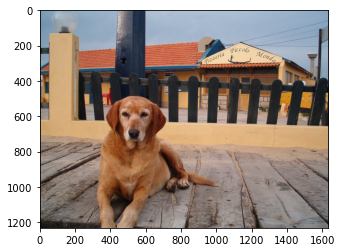

In [10]:
image_file_path = 'sample.jpg'
 

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 

def load_image(image_file_path, transform=None):
    img = Image.open(image_file_path).convert('RGB')
    img = img.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        img = transform(img).unsqueeze(0)
    
    return img
 

# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])


# Load vocabulary wrapper
with open('data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)


# Build models
encoder_model = CNNModel(256).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1)
encoder_model = encoder_model.to(device)
decoder_model = decoder_model.to(device)


# Load the trained model parameters
encoder_model.load_state_dict(torch.load('models_dir/encoder-2-3000.ckpt'))
decoder_model.load_state_dict(torch.load('models_dir/decoder-2-3000.ckpt'))


# Prepare an image
img = load_image(image_file_path, transform)
img_tensor = img.to(device)


# Generate an caption from the image
feat = encoder_model(img_tensor)
sampled_indices = decoder_model.sample(feat)
sampled_indices = sampled_indices[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)


# Convert word_ids to words
predicted_caption = []
for token_index in sampled_indices:
    word = vocabulary.i2w[token_index]
    predicted_caption.append(word)
    if word == '<end>':
        break
predicted_sentence = ' '.join(predicted_caption)


# Print out the image and the generated caption
%matplotlib inline
print (predicted_sentence)
img = Image.open(image_file_path)
plt.imshow(np.asarray(img))